## 2-moon classifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Getting the data

In [2]:
from sklearn.datasets import make_moons

n_samples = 1000
X, y = make_moons(n_samples, noise=.05, random_state=42)

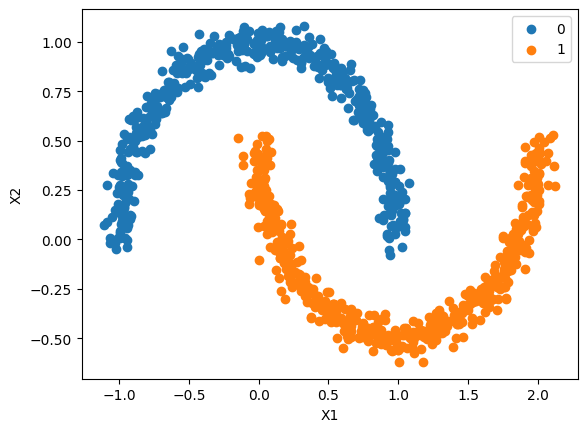

In [3]:
for i in np.unique(y):
    plt.scatter(X[np.where(y==i), 0], X[np.where(y==i), 1], label=i)
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

In [4]:
# Checking the shapes
X.shape, y.shape

((1000, 2), (1000,))

### Selecting the device and convertion data into tensors

In [5]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
X, y = torch.from_numpy(X).type(torch.float).to(device=device), torch.from_numpy(y).type(torch.float).to(device=device)

X[:5], y[:5]

(tensor([[-0.0214,  0.4062],
         [ 0.9767, -0.4583],
         [ 0.9041, -0.3765],
         [ 0.3774, -0.3970],
         [-0.8419,  0.5306]], device='cuda:0'),
 tensor([1., 1., 1., 1., 0.], device='cuda:0'))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [8]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [9]:
class CirclesClassifierV0(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.Tanh(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Tanh(),
            nn.Linear(in_features=hidden_units, out_features=out_features),
        )
    
    def forward(self, x):
        return self.layers(x)

In [10]:
model = CirclesClassifierV0(in_features=2, out_features=1, hidden_units=5).to(device=device)
model

CirclesClassifierV0(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Tanh()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): Tanh()
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [11]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [12]:
model(X_train)[0].shape, 1 # Check if we have the same number of output predictions that we need

(torch.Size([1]), 1)

In [13]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct / len(y_pred)) * 100
    return accuracy

In [14]:
torch.manual_seed(10)

epochs = 2000
logs = []

for epoch in range(epochs):
    model.train()

    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    accuracy = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(y_test, test_preds)
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}\nTrain loss: {loss:.5f}\nTrain accuracy: {accuracy:.2f}%\nTest loss: {test_loss:.5f}\nTest accuracy: {test_accuracy:.2f}%', end='\n\n')
    logs.append({
        'epoch': epoch,
        'train_loss': loss,
        'test_loss': test_loss,
        'train_accuracy': accuracy,
        'test_accuracy': test_accuracy
    })

Epoch: 0
Train loss: 0.74252
Train accuracy: 49.75%
Test loss: 0.72883
Test accuracy: 51.00%

Epoch: 10
Train loss: 0.69254
Train accuracy: 49.75%
Test loss: 0.68683
Test accuracy: 51.00%

Epoch: 20
Train loss: 0.66080
Train accuracy: 76.38%
Test loss: 0.65937
Test accuracy: 79.50%

Epoch: 30
Train loss: 0.63111
Train accuracy: 83.75%
Test loss: 0.63231
Test accuracy: 83.50%

Epoch: 40
Train loss: 0.59573
Train accuracy: 83.62%
Test loss: 0.59896
Test accuracy: 83.00%

Epoch: 50
Train loss: 0.55182
Train accuracy: 83.62%
Test loss: 0.55723
Test accuracy: 83.00%

Epoch: 60
Train loss: 0.50223
Train accuracy: 83.25%
Test loss: 0.51052
Test accuracy: 82.50%

Epoch: 70
Train loss: 0.45406
Train accuracy: 83.50%
Test loss: 0.46587
Test accuracy: 82.00%

Epoch: 80
Train loss: 0.41299
Train accuracy: 83.88%
Test loss: 0.42834
Test accuracy: 83.00%

Epoch: 90
Train loss: 0.38025
Train accuracy: 84.50%
Test loss: 0.39872
Test accuracy: 84.00%

Epoch: 100
Train loss: 0.35440
Train accuracy: 85.0

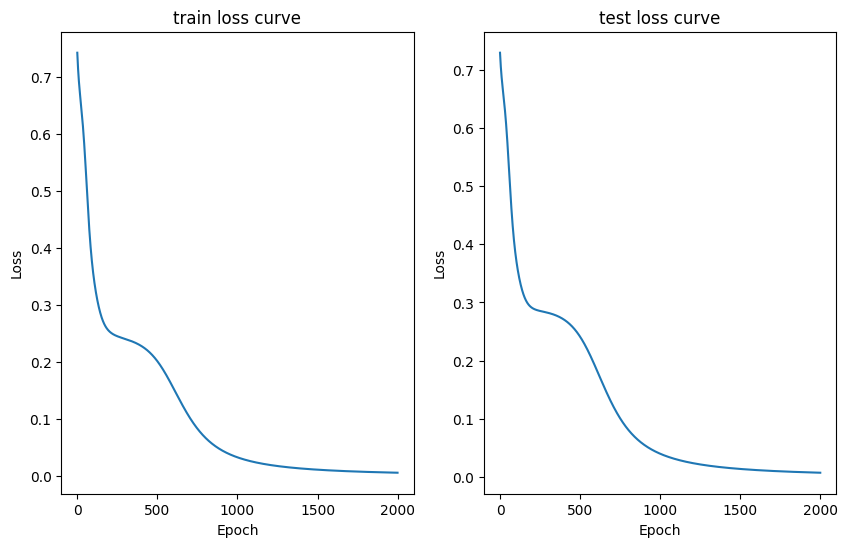

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
for i, type in enumerate(['train', 'test']):
    ax[i].set_title(f'{type} loss curve')
    ax[i].plot(range(epochs), [log.get(f'{type}_loss').item() for log in logs])
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Loss')

In [16]:
print(f"The final accuracy is: {logs[-1].get('test_accuracy')}%")

The final accuracy is: 100.0%
